In [396]:
import numpy as np
np.random.seed(42)
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
plt.style.use('ggplot')

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Dropout
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

#NLP tools
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [397]:
dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
test = pd.read_csv("civility_data/test.tsv", sep='\t')
train = pd.read_csv("civility_data/train.tsv", sep='\t')
mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

In [398]:
dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
test = pd.read_csv("civility_data/test.tsv", sep='\t')
train = pd.read_csv("civility_data/train.tsv", sep='\t')
mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

X_train = train["text"].values
y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])
X_test = dev["text"].values
y_test = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])
X_test_dev = mini_demographic_dev["text"].values
y_test_dev = mini_demographic_dev["bin_label"].values

# Clean text

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

# sentences = [
#     "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
#     "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
#     "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/."
# ]

# for s in sentences:
#     print(" ".join(text_processor.pre_process_doc(s)))

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
#     annotate={"hashtag", "allcaps", "elongated", "repeated",
#         'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 

    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)
    
def preprocessing(data):

    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    corpus = []
    for tweet in tqdm(data):
        review = tweet
        review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)  # remove emojis
        review = " ".join(text_processor.pre_process_doc(review))
        review = re.sub(r"@[A-Za-z0-9_]+", " ", review)
        review = re.sub('RT', ' ', review)
        review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
        review = re.sub(r"https?", " ", review)
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = re.sub('user', ' ', review)
        review = review.lower()
        review = review.split()
        review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
        review = ' '.join(review)
        corpus.append(review)

    return np.array(corpus)

print("Preprocessing tweets...")
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)
X_test_dev = preprocessing(X_test_dev)


# max_features = 16097
# maxlen = 260
# embedding_dim = 100

# tokenizer = text.Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)
# X_test_dev = tokenizer.texts_to_sequences(X_test_dev)
# X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
# X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
# X_test_dev = sequence.pad_sequences(X_test_dev, maxlen=maxlen)


# embeddings_index = dict()

# GLOVE_PATH = 'glove.twitter.27B.200d.txt'
# print("Processing GloVe word embeddings...")
# with open(GLOVE_PATH, 'r') as glove_file:
#     for line in glove_file:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

# print("Found", len(embeddings_index), "word vectors!")

# embedding_matrix = np.zeros((max_features, embedding_dim))
# print("Creating embedding matrix...")
# for i in tqdm(range(len(tokenizer.word_index.items()))):
#     word, index = list(tokenizer.word_index.items())[i]
#     if index > max_features-1:
#         break
#     else:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index] = embedding_vector

# with open('embedding_matrix_200.npy', 'wb') as f:
#     np.save(f, embedding_matrix)

with open('embedding_matrix.npy', 'rb') as f:
    embedding_matrix = np.load(f)

# with open('embedding_matrix_fasttext.npy', 'rb') as f:
#     embedding_matrix = np.load(f)

print('DONE')

Reading twitter - 1grams ...
Reading twitter - 2grams ...


  0%|          | 0/10592 [00:00<?, ?it/s]

Reading twitter - 1grams ...
Preprocessing tweets...


100%|██████████| 5072/5072 [00:03<00:00, 1457.80it/s]

DONE


In [399]:
race_test = pd.read_csv("civility_extra_data/demographic_dev.tsv", sep='\t')
race_train = pd.read_csv("civility_extra_data/demographic_train.tsv", sep='\t')
labeled = pd.read_csv("civility_extra_data/labeled_data.tsv", sep='\t')

In [400]:
rx_test = race_test["text"]
ry_test = race_test["demographic"]
rx_train = race_train["text"]
ry_train = race_train["demographic"]

In [401]:
race_test.head()

,text,demographic
0,@USER @USER he dropped him and picked up Vick,White
1,Right when I see a snap chat from @USER I get ...,White
2,I am getting way to many Waffle House snapchat...,White
3,I miss my roommate @USER so much \ud83d\ude2d\...,White
4,Joey MacDonald is playing really good for the ...,White


In [402]:
race_train.head()

,text,demographic
0,I just wanna make you happy,White
1,@USER I was laughing at that tweet you put smh...,White
2,Damn I hate bein sobaa' .. ima smokaa preferab...,AA
3,@USER right!!! Lmao xD he told me to delete it...,Hispanic
4,@USER ok I'll leave my class now!,White


<AxesSubplot:xlabel='demographic', ylabel='count'>

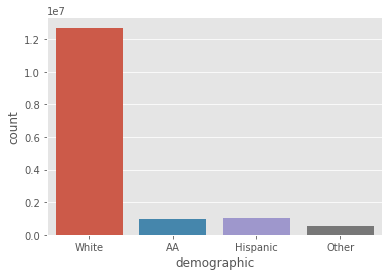

In [403]:
sns.countplot(race_train.demographic)

In [404]:
other_race = race_train[race_train.demographic == 'Other'].sample(250000)
white_race = race_train[race_train.demographic == 'White'].sample(250000)
AA_race = race_train[race_train.demographic == 'AA'].sample(250000)
hispanic_race = race_train[race_train.demographic == 'Hispanic'].sample(250000)

In [405]:
rtrain = pd.concat([other_race, white_race, AA_race, hispanic_race])

In [406]:
other_test = race_test[race_test.demographic == 'Other'].sample(50000)
white_test = race_test[race_test.demographic == 'White'].sample(50000)
AA_test = race_test[race_test.demographic == 'AA'].sample(50000)
hispanic_test = race_test[race_test.demographic == 'Hispanic'].sample(50000)

In [407]:
rtest = pd.concat([other_test, white_test, AA_test, hispanic_test])

In [408]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
ry_test = labelencoder.fit_transform(rtest.demographic)
ry_train = labelencoder.fit_transform(rtrain.demographic)

In [409]:
ry_test[0], ry_train[0]

(2, 2)

In [410]:
preprocessing([rx_train[0]])

100%|██████████| 1/1 [00:00<00:00, 386.86it/s]


array(['wanna make happy'], dtype='<U16')

In [116]:
# def preprocessing(data):
#     all_stopwords = stopwords.words('english')
#     all_stopwords.remove('not')
#     corpus = []
#     for tweet in tqdm(data):
#         review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
#         review = re.sub('RT', ' ', review)
#         review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
#         review = re.sub(r"https?", " ", review)
#         review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)
#         review = re.sub('[^a-zA-Z]', ' ', review)
#         review = review.lower()
#         review = review.split()
#         review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
#         review = ' '.join(review)
#         corpus.append(review)

#     return np.array(corpus)

In [413]:
preprocessing(rtrain.text.values[:5])

100%|██████████| 5/5 [00:00<00:00, 1703.75it/s]


array(['apo entiende toy trabajando',
       'que sabes que que sabemos que ambos sabemos que quisieras estar este lugar llueven los pensamientos',
       'ciudad mientras estamos bat tango',
       'gaby sai chon extrano tenes que poner dia todo', ''], dtype='<U99')

In [414]:
rx_train = preprocessing([x if isinstance(x, str) else '' for x in rtrain.text.values])
rx_test = preprocessing(rtest.text.values)

100%|██████████| 200000/200000 [02:11<00:00, 1523.91it/s]


In [415]:
len([x for x in rx_train if x == '']) * 100 / len([x for x in rx_train if x != ''])

7.731803829003772

In [416]:
#max([len(x) for x in rx_train])

In [418]:
r_train = pd.DataFrame()
r_train['text'] = rx_train
r_train['label'] = ry_train

In [422]:
r_train = r_train[r_train.text != '']

In [423]:
rx_train = r_train['text']
ry_train = r_train['label']

In [424]:
len([x for x in rx_train if x == '']) * 100 / len([x for x in rx_train if x != ''])

0.0

In [425]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [426]:
logr = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression(solver='liblinear', penalty='l2')),
])

logr.fit(rx_train, ry_train)
ry_pred = logr.predict(rx_test)
print(accuracy_score(ry_test, ry_pred))
print(classification_report(ry_test, ry_pred))

0.70674
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     50000
           1       0.59      0.51      0.55     50000
           2       0.85      0.95      0.90     50000
           3       0.62      0.67      0.65     50000

    accuracy                           0.71    200000
   macro avg       0.70      0.71      0.70    200000
weighted avg       0.70      0.71      0.70    200000



In [538]:
logr.predict_proba(rx_test[:1])

array([[0.01046764, 0.00436868, 0.97773966, 0.00742401]])

In [537]:
import pickle

filename = 'race_model.sav'
pickle.dump(logr, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(rx_test, ry_test)
print(result)

0.70674


In [428]:
nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB()),
])

nb.fit(rx_train, ry_train)
ry_pred = nb.predict(rx_test)
print(accuracy_score(ry_test, ry_pred))
print(classification_report(ry_test, ry_pred))

0.660145
              precision    recall  f1-score   support

           0       0.76      0.66      0.71     50000
           1       0.58      0.53      0.55     50000
           2       0.95      0.73      0.83     50000
           3       0.49      0.72      0.58     50000

    accuracy                           0.66    200000
   macro avg       0.70      0.66      0.67    200000
weighted avg       0.70      0.66      0.67    200000



In [437]:
# max_features = 16097
# maxlen = 260
# embedding_dim = 100

# X_train = rx_train
# y_train = ry_train
# X_test = rx_test
# y_test = ry_test

# print('tokenizing')
# tokenizer = text.Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)
# # X_test_dev = tokenizer.texts_to_sequences(X_test_dev)
# X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
# X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
# # X_test_dev = sequence.pad_sequences(X_test_dev, maxlen=maxlen)

# embeddings_index = dict()

# GLOVE_PATH = 'glove.twitter.27B.100d.txt'
# print("Processing GloVe word embeddings...")
# with open(GLOVE_PATH, 'r') as glove_file:
#     for line in glove_file:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

# print("Found", len(embeddings_index), "word vectors!")

# embedding_matrix = np.zeros((max_features, embedding_dim))
# print("Creating embedding matrix...")
# for i in tqdm(range(len(tokenizer.word_index.items()))):
#     word, index = list(tokenizer.word_index.items())[i]
#     if index > max_features-1:
#         break
#     else:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index] = embedding_vector

# with open('embedding_matrix_race.npy', 'wb') as f:
#     np.save(f, embedding_matrix)

tokenizing
Processing GloVe word embeddings...


  0%|          | 2/229638 [00:00<4:47:15, 13.32it/s]

Found 1193514 word vectors!
Creating embedding matrix...


  2%|▏         | 5555/229638 [04:56<3:19:39, 18.71it/s] 


KeyboardInterrupt: 

In [514]:
def run_race(model, model_name='', batch_size=32, epochs=20):
    

#     batch_size = 32
#     epochs = 20
    tf.keras.utils.plot_model(
        model, to_file=model_name+'model.png', show_shapes=False, show_dtype=False,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
        layer_range=None, show_layer_activations=False
    )

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss vs. Epochs')
    plt.legend()
    plt.savefig(model_name + '_loss.png')
    plt.show()
    plt.close()

    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training accuracy vs. Epochs')
    plt.legend()
    plt.savefig(model_name + '_accuracy.png')
    plt.show()
    plt.close()

    y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
    y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]
    
    print("================================================")

    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)
    fig = sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.savefig(model_name + "_cm.png")
    plt.close()

    model.save(model_name + '.h5')


def run(model, model_name='', batch_size=32, epochs=20):

#     batch_size = 32
#     epochs = 20
    tf.keras.utils.plot_model(
        model, to_file=model_name+'model.png', show_shapes=False, show_dtype=False,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
        layer_range=None, show_layer_activations=False
    )

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss vs. Epochs')
    plt.legend()
    plt.savefig(model_name + '_loss.png')
    plt.show()
    plt.close()

    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training accuracy vs. Epochs')
    plt.legend()
    plt.savefig(model_name + '_accuracy.png')
    plt.show()
    plt.close()


    y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
    y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]
    
    print("================================================")

    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)
    fig = sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.savefig(model_name + "_cm.png")
    plt.close()

    model.save(model_name + '.h5')
    
    # Test on demographic
    y_pred_dev = model.predict(X_test_dev)
    y_pred_dev = [0 if y[0] < 0.5 else 1 for y in y_pred_dev]
    
    print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(y_test_dev, y_pred_dev) * 100))
    print("F1 Score mini_dem: {:.6f}".format(f1_score(y_test_dev, y_pred_dev)))

    mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

    white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
    hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
    AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
    other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

    white_fpr = get_fpr(white_df)
    hispanic_fpr = get_fpr(hispanic_df)
    AA_fpr = get_fpr(AA_df)
    other_fpr = get_fpr(other_df)
    
    print("")
    print("White FPR:", white_fpr)
    print("Hispanic FPR:", hispanic_fpr)
    print("AA FPR:", AA_fpr)
    print("Other FPR:", other_fpr)
    
def get_measure(y_actual, y_pred):
    CM = confusion_matrix(1-y_actual, 1-y_pred, labels=[0, 1])

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    return (TP, FP, TN, FN)

def get_fpr(df):
    TP, FP, TN, FN = get_measure(df["bin_label"].values, df["pred_label"].values)
    return FP/(FP+TN)

def get_fpr_(y_actual, y_pred):
    TP, FP, TN, FN = get_measure(y_actual, y_pred)
    return FP/(FP+TN)

In [511]:
def shallow_model():
    embedded = keras.layers.Embedding(max_features, embedding_dim)
    # embedded = keras.layers.Embedding(max_features+1, 300, weights=[embedding_matrix], trainable=False)
    # Accuracy: 75.23%
    # F1 Score: 0.826271
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())

    return model

In [440]:
run_race(shallow_model(), 'shallow_model_race', epochs=50)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 100)         1609700   
                                                                 
 global_average_pooling1d_27  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_78 (Dense)            (None, 16)                1616      
                                                                 
 dense_79 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,611,333
Trainable params: 1,611,333
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 2048/26107 [=>............................] - ETA: 4:53 - loss: -1850.5399 - accuracy: 0.179

KeyboardInterrupt: 

In [441]:
max([len(x) for x in rx_test])

275

In [442]:
X_train = preprocessing(train["text"].values)
y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])

train = pd.DataFrame()
train['text'] = X_train
train['label'] = y_train

100%|██████████| 10592/10592 [00:12<00:00, 877.16it/s]


In [443]:
train['text'] = preprocessing(train.text.values)
train['len'] = [len(x.split(' ')) for x in train.text.values]
train = train[train['len'] > 2]

train

100%|██████████| 10592/10592 [00:05<00:00, 1766.82it/s]


,text,label,len
1,seems hard believe stood next guy wearing shor...,0.0,12
2,wow wonder liberals got worse party bullies wo...,0.0,9
3,not idiots grandstands like,0.0,4
4,bring hypocrite gungrabber maga,0.0,4
6,thing agree match point following rules think ...,0.0,14
...,...,...,...
10586,retweet complete followed patriots,1.0,4
10587,sometimes get strong vibes people man vibe ten...,0.0,11
10588,benidorm creamfields maga not shabby summer,1.0,6
10589,report garbage not give crap,0.0,5


In [444]:
probs = logr.predict_proba(train['text'])
train['probs'] = [prob for prob in probs]

In [445]:
train

,text,label,len,probs
1,seems hard believe stood next guy wearing shor...,0.0,12,"[0.0712686067237616, 0.32430757615070627, 0.00..."
2,wow wonder liberals got worse party bullies wo...,0.0,9,"[0.211551039996638, 0.19189610357427925, 0.006..."
3,not idiots grandstands like,0.0,4,"[0.04095586239507361, 0.5096916841582952, 0.00..."
4,bring hypocrite gungrabber maga,0.0,4,"[0.08910305280808187, 0.3616511737120119, 0.10..."
6,thing agree match point following rules think ...,0.0,14,"[0.2425095571747166, 0.2587174160725592, 0.000..."
...,...,...,...,...
10586,retweet complete followed patriots,1.0,4,"[0.1344428629732509, 0.1492685201785934, 0.031..."
10587,sometimes get strong vibes people man vibe ten...,0.0,11,"[0.11521956770918694, 0.3824784810648912, 0.00..."
10588,benidorm creamfields maga not shabby summer,1.0,6,"[0.10734921802261195, 0.1776701610733089, 0.13..."
10589,report garbage not give crap,0.0,5,"[0.022548604945529765, 0.2297323274426076, 0.0..."


In [446]:
uniform = [0.25, 0.25, 0.25, 0.25]

In [447]:
uniform = [0.25, 0.25, 0.25, 0.25]
dist = lambda x: np.sqrt(np.sum(np.square(x - uniform)))

In [448]:
dist(train['probs'].values[0])

0.4747797420954194

In [449]:
train['dist'] = train['probs'].apply(dist)

In [450]:
train.describe()

,label,len,dist
count,9303.000000,9303.000000,9303.000000
mean,0.657745,11.839407,0.475705
std,0.474490,7.448368,0.135198
min,0.000000,3.000000,0.026554
25%,0.000000,6.000000,0.378520
50%,1.000000,10.000000,0.478014
75%,1.000000,17.000000,0.574869
max,1.000000,41.000000,0.845434


In [451]:
train.label

1        0.0
2        0.0
3        0.0
4        0.0
6        0.0
        ... 
10586    1.0
10587    0.0
10588    1.0
10589    0.0
10591    1.0
Name: label, Length: 9303, dtype: float64

In [452]:
new_train = train.sort_values('dist')[:5000]
indices = sorted(new_train.index)

In [453]:
new_train['probs'].apply(lambda x: np.round(x, decimals=3))

4311     [0.243, 0.243, 0.241, 0.273]
6916     [0.223, 0.249, 0.259, 0.268]
2784      [0.23, 0.235, 0.262, 0.273]
9932     [0.242, 0.284, 0.227, 0.247]
7924     [0.212, 0.262, 0.253, 0.273]
                     ...             
7359       [0.14, 0.144, 0.046, 0.67]
239       [0.008, 0.422, 0.011, 0.56]
1160     [0.046, 0.345, 0.001, 0.608]
10349     [0.135, 0.19, 0.014, 0.661]
5186     [0.314, 0.056, 0.006, 0.624]
Name: probs, Length: 5000, dtype: object

In [454]:
train['max_prob'] = train['probs'].apply(max)

In [455]:
train.describe()

,label,len,dist,max_prob
count,9303.000000,9303.000000,9303.000000,9303.000000
mean,0.657745,11.839407,0.475705,0.623911
std,0.474490,7.448368,0.135198,0.140664
min,0.000000,3.000000,0.026554,0.268397
25%,0.000000,6.000000,0.378520,0.513509
50%,1.000000,10.000000,0.478014,0.628696
75%,1.000000,17.000000,0.574869,0.734716
max,1.000000,41.000000,0.845434,0.982126


In [486]:
new_train2 = train.sort_values('max_prob')[:5000]
indices = sorted(new_train2.index)

In [457]:
new_train3 = train[train['max_prob'] <= 0.50]
indices = sorted(new_train3.index)

In [487]:
max(indices)

10591

In [488]:
new_train3.loc[10587

text        sometimes get strong vibes people man vibe ten...
label                                                     0.0
len                                                        11
probs       [0.11521956770918694, 0.3824784810648912, 0.00...
dist                                                 0.392923
max_prob                                             0.494738
Name: 10587, dtype: object

In [493]:
# dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
# mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
# test = pd.read_csv("civility_data/test.tsv", sep='\t')
# train = pd.read_csv("civility_data/train.tsv", sep='\t')
# mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

# X_train = train["text"].values
# y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])
X_test = dev["text"].values
y_test = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])
X_test_dev = mini_demographic_dev["text"].values
y_test_dev = mini_demographic_dev["bin_label"].values

# Clean text
# def preprocessing(data):
#     all_stopwords = stopwords.words('english')
#     all_stopwords.remove('not')
#     corpus = []
#     for tweet in data:
#         review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
#         review = re.sub('RT', ' ', review)d
#         review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
#         review = re.sub(r"https?", " ", review)
#         review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)
#         review = re.sub('[^a-zA-Z]', ' ', review)
#         review = review.lower()
#         review = review.split()
#         review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
#         review = ' '.join(review)
#         corpus.append(review)

#     return np.array(corpus)

print("Preprocessing tweets...")
# X_train = preprocessing(X_train)
X_test = preprocessing(X_test)
X_test_dev = preprocessing(X_test_dev)

# X_train = train.iloc[indices]['text']
# y_train = train.iloc[indices]['label']
X_train = train['text']
y_train = train['label']

print(len(train))

max_features = 16097
maxlen = 100
embedding_dim = 100

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train.loc[indices])
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = train.loc[indices]['label']

X_test = tokenizer.texts_to_sequences(X_test)
X_test_dev = tokenizer.texts_to_sequences(X_test_dev)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
X_test_dev = sequence.pad_sequences(X_test_dev, maxlen=maxlen)


embeddings_index = dict()

GLOVE_PATH = 'glove.twitter.27B.100d.txt'
print("Processing GloVe word embeddings...")
with open(GLOVE_PATH, 'r') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found", len(embeddings_index), "word vectors!")

embedding_matrix = np.zeros((max_features, embedding_dim))
print("Creating embedding matrix...")
for i in tqdm(range(len(tokenizer.word_index.items()))):
    word, index = list(tokenizer.word_index.items())[i]
    if index > max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

with open('embedding_matrix_balanced.npy', 'wb') as f:
    np.save(f, embedding_matrix)

# with open('embedding_matrix.npy', 'rb') as f:
#     embedding_matrix = np.load(f)

# with open('embedding_matrix_fasttext.npy', 'rb') as f:
#     embedding_matrix = np.load(f)

print('DONE')

  7%|▋         | 99/1324 [00:00<00:01, 988.23it/s]

Preprocessing tweets...


100%|██████████| 5072/5072 [00:07<00:00, 719.06it/s]


9303
Processing GloVe word embeddings...


  0%|          | 8/15136 [00:00<03:22, 74.57it/s]

Found 1193514 word vectors!
Creating embedding matrix...


100%|██████████| 15136/15136 [02:22<00:00, 106.01it/s]


DONE


In [490]:
len(X_train)

5000

In [528]:
def recurrent_cnn1():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)),
        keras.layers.Convolution1D(64, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_14 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_14 (Bidirecti  (None, None, 128)        84480     
 onal)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, None, 64)          24640     
                                                                 
 global_max_pooling1d_14 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                     

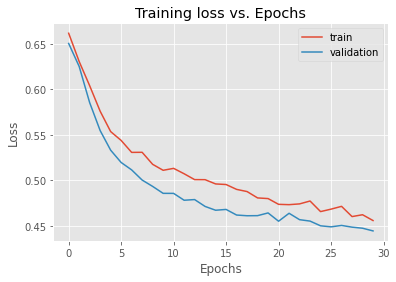

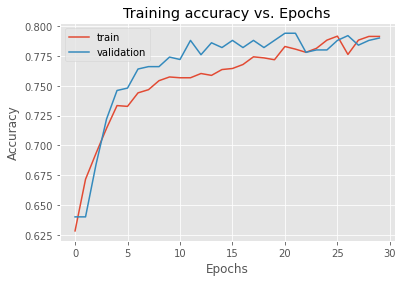

42/42 [==============================] - 3s 28ms/step
Accuracy: 77.57%
F1 Score: 0.842440
Accuracy on mini_dem: 85.35%
F1 Score mini_dem: 0.920966

White FPR: 0.14285714285714285
Hispanic FPR: 0.16119402985074627
AA FPR: 0.25301204819277107
Other FPR: 0.0


In [529]:
run(recurrent_cnn1(), 'recurrent_cnn1_balanced', epochs=30)

In [515]:
def shallow_model():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)
    # embedded = keras.layers.Embedding(max_features+1, 300, weights=[embedding_matrix], trainable=False)
    # Accuracy: 75.23%
    # F1 Score: 0.826271
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())

    return model

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, None, 100)         1609700   
                                                                 
 global_average_pooling1d_36  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_98 (Dense)            (None, 64)                6464      
                                                                 
 dense_99 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,616,229
Trainable params: 6,529
Non-trainable params: 1,609,700
_________________________________________________________________
None
Epoch 1/100
141/141 [==============================] - 2s 6ms/step - loss: 0.6368 - accuracy: 0.6718

Epoch 51/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4513 - accuracy: 0.7918 - val_loss: 0.4881 - val_accuracy: 0.7560
Epoch 52/100
141/141 [==============================] - 1s 5ms/step - loss: 0.4510 - accuracy: 0.7918 - val_loss: 0.4855 - val_accuracy: 0.7640
Epoch 53/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4498 - accuracy: 0.7900 - val_loss: 0.4853 - val_accuracy: 0.7580
Epoch 54/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4499 - accuracy: 0.7918 - val_loss: 0.4846 - val_accuracy: 0.7640
Epoch 55/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4480 - accuracy: 0.7931 - val_loss: 0.4862 - val_accuracy: 0.7600
Epoch 56/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4471 - accuracy: 0.7924 - val_loss: 0.4871 - val_accuracy: 0.7580
Epoch 57/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4473 - accuracy: 0.7956 - val_loss: 0.4849 - val_accuracy:

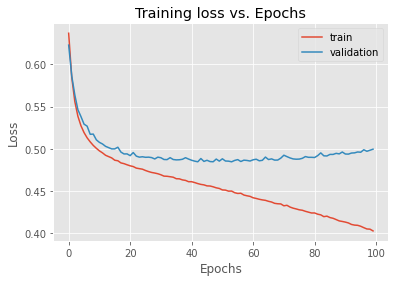

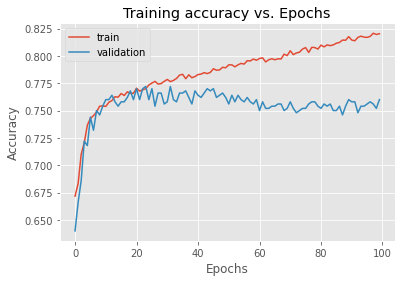

42/42 [==============================] - 0s 3ms/step
Accuracy: 74.32%
F1 Score: 0.819915
Accuracy on mini_dem: 85.67%
F1 Score mini_dem: 0.922799

White FPR: 0.14214876033057852
Hispanic FPR: 0.1582089552238806
AA FPR: 0.21686746987951808
Other FPR: 0.0


In [516]:
shallow_model = shallow_model()
run(shallow_model, 'shallow2', epochs=100)

In [500]:
def recurrent_cnn():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True)),
        keras.layers.Convolution1D(64, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_12 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_12 (Bidirecti  (None, None, 128)        63744     
 onal)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, None, 64)          24640     
                                                                 
 global_max_pooling1d_12 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                     

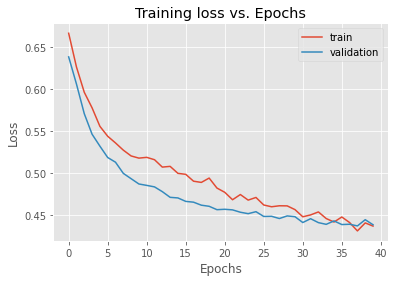

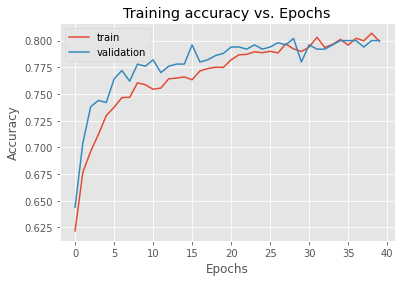

42/42 [==============================] - 6s 28ms/step
Accuracy: 78.47%
F1 Score: 0.849921
Accuracy on mini_dem: 86.04%
F1 Score mini_dem: 0.924968

White FPR: 0.1371900826446281
Hispanic FPR: 0.14626865671641792
AA FPR: 0.23493975903614459
Other FPR: 0.0


In [501]:
run(recurrent_cnn(), 'recurrent_cnn_balanced', epochs=40)

In [532]:
def recurrent_cnn2():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True)),
        keras.layers.Convolution1D(32, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.40),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_16 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_17 (Bidirecti  (None, None, 128)        63744     
 onal)                                                           
                                                                 
 bidirectional_18 (Bidirecti  (None, None, 128)        74496     
 onal)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, None, 32)          12320     
                                                     

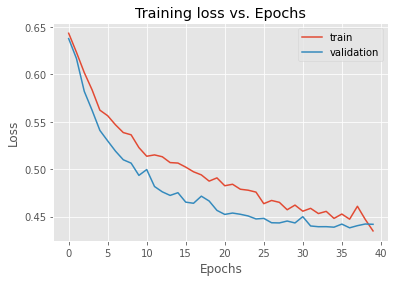

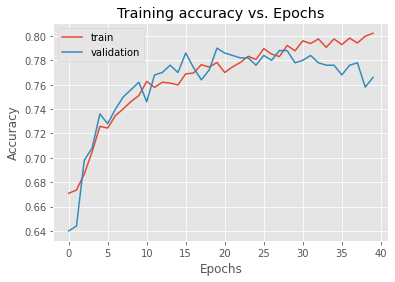

42/42 [==============================] - 2s 25ms/step
Accuracy: 76.89%
F1 Score: 0.831683
Accuracy on mini_dem: 82.43%
F1 Score mini_dem: 0.903707

White FPR: 0.17331759149940967
Hispanic FPR: 0.18208955223880596
AA FPR: 0.2891566265060241
Other FPR: 0.0


In [533]:
run(recurrent_cnn2(), 'recurrent_cnn2_balanced', epochs=40)

In [483]:
np.round(train.loc[max(indices)].probs, decimals=2)

array([0.12, 0.38, 0.01, 0.49])

In [496]:
xtr = train.loc[indices]['text']
ytr = train.loc[indices]['label']

xte = dev["text"].values
yte = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

logr2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression(solver='liblinear', penalty='l2')),
])

logr2.fit(xtr, ytr)
ypre = logr2.predict(xte)
print(accuracy_score(yte, ypre))
print(classification_report(yte, ypre))

0.7326283987915407
              precision    recall  f1-score   support

         0.0       0.79      0.27      0.40       440
         1.0       0.73      0.96      0.83       884

    accuracy                           0.73      1324
   macro avg       0.76      0.62      0.61      1324
weighted avg       0.75      0.73      0.69      1324



In [497]:
xtde = mini_demographic_dev["text"].values
ytde = mini_demographic_dev["bin_label"].values

y_pred_dev = logr2.predict(xtde)

print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(ytde, y_pred_dev) * 100))
print("F1 Score mini_dem: {:.6f}".format(f1_score(ytde, y_pred_dev)))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

Accuracy on mini_dem: 91.07%
F1 Score mini_dem: 0.953256

White FPR: 0.08311688311688312
Hispanic FPR: 0.10746268656716418
AA FPR: 0.19578313253012047
Other FPR: 0.0


In [498]:
xtr = train.loc[indices]['text']
ytr = train.loc[indices]['label']

xte = dev["text"].values
yte = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB()),])

nb.fit(xtr, ytr)
ypre = nb.predict(xte)
print(accuracy_score(yte, ypre))
print(classification_report(yte, ypre))

0.709214501510574
              precision    recall  f1-score   support

         0.0       0.81      0.16      0.27       440
         1.0       0.70      0.98      0.82       884

    accuracy                           0.71      1324
   macro avg       0.76      0.57      0.55      1324
weighted avg       0.74      0.71      0.64      1324



In [499]:
xtde = mini_demographic_dev["text"].values
ytde = mini_demographic_dev["bin_label"].values

y_pred_dev = nb.predict(xtde)

print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(ytde, y_pred_dev) * 100))
print("F1 Score mini_dem: {:.6f}".format(f1_score(ytde, y_pred_dev)))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

Accuracy on mini_dem: 93.75%
F1 Score mini_dem: 0.967742

White FPR: 0.0590318772136954
Hispanic FPR: 0.056716417910447764
AA FPR: 0.1355421686746988
Other FPR: 0.01764705882352941


In [519]:
xtr = train.loc[indices]['text']
ytr = train.loc[indices]['label']

xte = dev["text"].values
yte = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

m = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('m', XGBClassifier()),])

m.fit(xtr, ytr)
ypre = m.predict(xte)
print(accuracy_score(yte, ypre))
print(classification_report(yte, ypre))

xtde = mini_demographic_dev["text"].values
ytde = mini_demographic_dev["bin_label"].values

y_pred_dev = m.predict(xtde)

print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(ytde, y_pred_dev) * 100))
print("F1 Score mini_dem: {:.6f}".format(f1_score(ytde, y_pred_dev)))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

[18:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7515105740181269
              precision    recall  f1-score   support

         0.0       0.75      0.38      0.50       440
         1.0       0.75      0.94      0.83       884

    accuracy                           0.75      1324
   macro avg       0.75      0.66      0.67      1324
weighted avg       0.75      0.75      0.72      1324

Accuracy on mini_dem: 92.09%
F1 Score mini_dem: 0.958842

White FPR: 0.07579693034238488
Hispanic FPR: 0.08358208955223881
AA FPR: 0.1566265060240964
Other FPR: 0.0


In [520]:
xtr = train.loc[indices]['text']
ytr = train.loc[indices]['label']

xte = dev["text"].values
yte = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

m = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('m', GradientBoostingClassifier()),])

m.fit(xtr, ytr)
ypre = m.predict(xte)
print(accuracy_score(yte, ypre))
print(classification_report(yte, ypre))

xtde = mini_demographic_dev["text"].values
ytde = mini_demographic_dev["bin_label"].values

y_pred_dev = m.predict(xtde)

print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(ytde, y_pred_dev) * 100))
print("F1 Score mini_dem: {:.6f}".format(f1_score(ytde, y_pred_dev)))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

0.7401812688821753
              precision    recall  f1-score   support

         0.0       0.83      0.27      0.41       440
         1.0       0.73      0.97      0.83       884

    accuracy                           0.74      1324
   macro avg       0.78      0.62      0.62      1324
weighted avg       0.76      0.74      0.69      1324

Accuracy on mini_dem: 93.30%
F1 Score mini_dem: 0.965320

White FPR: 0.06233766233766234
Hispanic FPR: 0.07462686567164178
AA FPR: 0.1536144578313253
Other FPR: 0.0


In [521]:
xtr = train.loc[indices]['text']
ytr = train.loc[indices]['label']

xte = dev["text"].values
yte = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

m = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('m', SVC()),])

m.fit(xtr, ytr)
ypre = m.predict(xte)
print(accuracy_score(yte, ypre))
print(classification_report(yte, ypre))

xtde = mini_demographic_dev["text"].values
ytde = mini_demographic_dev["bin_label"].values

y_pred_dev = m.predict(xtde)

print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(ytde, y_pred_dev) * 100))
print("F1 Score mini_dem: {:.6f}".format(f1_score(ytde, y_pred_dev)))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

0.7326283987915407
              precision    recall  f1-score   support

         0.0       0.82      0.25      0.38       440
         1.0       0.72      0.97      0.83       884

    accuracy                           0.73      1324
   macro avg       0.77      0.61      0.61      1324
weighted avg       0.76      0.73      0.68      1324

Accuracy on mini_dem: 92.29%
F1 Score mini_dem: 0.959910

White FPR: 0.07083825265643448
Hispanic FPR: 0.09253731343283582
AA FPR: 0.18072289156626506
Other FPR: 0.0


In [524]:
xtr = train.loc[indices]['text']
ytr = train.loc[indices]['label']

xte = dev["text"].values
yte = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

m = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('m', LinearSVC()),])

m.fit(xtr, ytr)
ypre = m.predict(xte)
print(accuracy_score(yte, ypre))
print(classification_report(yte, ypre))

xtde = mini_demographic_dev["text"].values
ytde = mini_demographic_dev["bin_label"].values

y_pred_dev = m.predict(xtde)

print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(ytde, y_pred_dev) * 100))
print("F1 Score mini_dem: {:.6f}".format(f1_score(ytde, y_pred_dev)))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

0.7477341389728097
              precision    recall  f1-score   support

         0.0       0.66      0.49      0.56       440
         1.0       0.78      0.88      0.82       884

    accuracy                           0.75      1324
   macro avg       0.72      0.68      0.69      1324
weighted avg       0.74      0.75      0.74      1324

Accuracy on mini_dem: 81.90%
F1 Score mini_dem: 0.900499

White FPR: 0.17615112160566707
Hispanic FPR: 0.18507462686567164
AA FPR: 0.2891566265060241
Other FPR: 0.08235294117647059
